# Face recognition

Juan Camilo Azuero

## Introduction

This notebook is part of the final project of the course Introduction to Deep Learning from the University of Colorado Boulder. The goal of the project is to create a face recognition application that is capable of recognizing someone based on a couple of pictures. There are many models deployed with such capabilities powering applications like the face id unlock feature some cellphones have.   

## Imports and setup

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from matplotlib.image import imread
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
FACES_DIR = "/../Data/Faces"
FACES_CSV = "/../Data/faces_dir.csv"

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

This project is based on the Kaggle dataset <a href="https://www.kaggle.com/datasets/quadeer15sh/lfw-facial-recognition">LFW - Facial Recognition</a> that contains around 13,233 labelled pictures of 5,749 distinct famous people. The pictures are stored in .jpg format and all of them have a size of (250, 250, 3) including the RGB channels. This dataset has high bias and should not be used for any commercial purpose as stated in Kaggle, but it will serve to create a demo of the face pairing model. 

First, let's create a pandas dataframe with information about the diferent pictures in the dataset.

In [4]:
CWD = os.getcwd()

<IPython.core.display.Javascript object>

In [5]:
def create_faces_dir(faces_url: str, faces_csv: str):
    """Creates dir of labelled images of faces"""
    faces = os.listdir(CWD + faces_url)
    faces_df = pd.DataFrame(columns=["address"], data=faces)
    faces_df["number"] = faces_df["address"].apply(
        lambda x: int(x.split("_")[-1].split(".")[0])
    )
    faces_df["name"] = faces_df["address"].apply(lambda x: " ".join(x.split("_")[:-1]))
    faces_df.to_csv(CWD + faces_csv)

<IPython.core.display.Javascript object>

In [6]:
# create_faces_dir(FACES_DIR, FACES_CSV)

<IPython.core.display.Javascript object>

In [7]:
faces_df = pd.read_csv(CWD + FACES_CSV, index_col=0)

<IPython.core.display.Javascript object>

This dataframe contains information about the address of the picture, the numbber of pictures available for that person, and his name. 

In [8]:
faces_df.head()

,address,number,name
0,Kevin_Gil_0001.jpg,1,Kevin Gil
1,Gerry_Kelly_0001.jpg,1,Gerry Kelly
2,Eliane_Karp_0003.jpg,3,Eliane Karp
3,Vojislav_Kostunica_0006.jpg,6,Vojislav Kostunica
4,Phil_Johnson_0001.jpg,1,Phil Johnson


<IPython.core.display.Javascript object>

In [9]:
num_unique = len(faces_df["name"].unique())
print(
    f"There are {len(faces_df)} pictures and {num_unique} distinct persons in the dataset"
)

There are 13233 pictures and 5749 distinct persons in the dataset


<IPython.core.display.Javascript object>

The number of pictures for the 20 people with more images ranges between 530 for George Bush, and 39 for Hans Blix.

In [10]:
picture_counts = faces_df["name"].value_counts()
picture_counts.head(20)

George W Bush                530
Colin Powell                 236
Tony Blair                   144
Donald Rumsfeld              121
Gerhard Schroeder            109
Ariel Sharon                  77
Hugo Chavez                   71
Junichiro Koizumi             60
Jean Chretien                 55
John Ashcroft                 53
Jacques Chirac                52
Serena Williams               52
Vladimir Putin                49
Luiz Inacio Lula da Silva     48
Gloria Macapagal Arroyo       44
Arnold Schwarzenegger         42
Jennifer Capriati             42
Laura Bush                    41
Lleyton Hewitt                41
Hans Blix                     39
Name: name, dtype: int64

<IPython.core.display.Javascript object>

In contrast, more than 2/3 of the notable people in this dataset only have one picture available.

(0.0, 50.0)

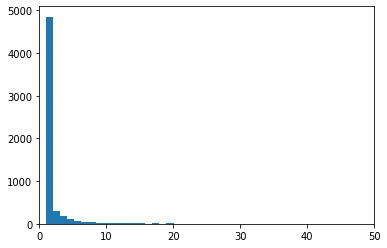

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots()
ax.hist(picture_counts.values, bins=500)
ax.set_xlim(0, 50)

In [12]:
print(
    f"""There are {len(faces_df)} pictures and {num_unique} distinct persons in the dataset.
Only {num_unique-(picture_counts == 1).sum()} have more than 1 picture"""
)

There are 13233 pictures and 5749 distinct persons in the dataset.
Only 1680 have more than 1 picture


<IPython.core.display.Javascript object>

This dataset is very far from being a good representation of the diversity in the world and has a strong bias. For further iterations of the model another dataset should be contructed according to the application requirements and ethical implications. More information about the *Labeled Faces in the Wild* dataset can be found in this <a href="http://vis-www.cs.umass.edu/lfw/#reference">reference</a> from the University of Massachusetts Amherst.

Concluding the disclaimer, let's split the pictures into train, validation and test sets. The train set is includes 60% of the 5749 different notables, while the validation and test set will contain 20% each. 

In [13]:
training_set = set(
    np.random.choice(
        faces_df["name"].unique(), size=int(num_unique * 0.6), replace=False
    )
)

<IPython.core.display.Javascript object>

In [14]:
cv_set = set(
    np.random.choice(
        list(set(faces_df["name"].unique()) - training_set),
        size=int(num_unique * 0.2),
        replace=False,
    )
)

<IPython.core.display.Javascript object>

In [15]:
test_set = (set(faces_df["name"].unique()) - training_set) - cv_set

<IPython.core.display.Javascript object>

In [16]:
faces_df_train = faces_df[faces_df["name"].isin(training_set)]
faces_df_cv = faces_df[faces_df["name"].isin(cv_set)]
faces_df_test = faces_df[faces_df["name"].isin(test_set)]

<IPython.core.display.Javascript object>

## ETL 

The proposed model for the task is a CNN with an input of two images and a single binary output that indicate if the two images come from the same person. In order to optimize the training both inputs go through the same feature extraction submodel, and then the outputs are concatenated and input a dense neural network that classify the images.

![picture](../Images/CNN_diagram.png)

For the construction of this model Keras will be used in top of the tensorflow backend. Thus, in order to train a NN we need to create a tensorflow dataset object. The next cell creates a generator that produces with probability 1/2 a pair of pictures from the same person and with probability 1/2 pictures from different people. The image pair generator concatenates both images into a unique np array and does a horizantal random flip of the image for data augmentation.

In [17]:
class ImagePairDataset:
    def __init__(
        self, 
        df,
        size=10000,
        prop_same=0.5,
        train=True,
    ):
        # df with addresses of the images
        self.df = df
        # Simulated size of dataset (ITS RANDOM GENERATION)
        self.size = size
        # Proportion of picture pairs from 1 person
        self.prop_same = prop_same
        # Train flag used to include randomflip
        self.train = train
        
        val_counts = df["name"].value_counts()
        self.val_counts_rep = val_counts[val_counts > 1]

    def __len__(self):
        return self.size

    def __getitem__(self,idx):
        same = None
        sample_inds=None
        if np.random.rand() < self.prop_same:
            # Generation of pictures from same person
            person_to_sample = self.val_counts_rep[
                self.val_counts_rep.cumsum() > np.random.randint((self.val_counts_rep).sum())
            ].index[0]
            sample_inds = np.random.choice(
                self.df[self.df["name"] == person_to_sample]["address"].values, 2,
            )
            same = 1
        else:
            # Generation of pictures from different people
            sample_inds = np.random.choice(self.df.index, 2)
            while self.df.loc[sample_inds[0], "name"] == self.df.loc[sample_inds[1], "name"]:
                sample_inds = np.random.choice(self.df.index, 2)
            sample_inds = tuple(self.df.loc[sample_inds,'address'])
            same = 0
        im_1 = self.randomflip(imread(CWD + FACES_DIR + "/" + sample_inds[0]) / 127.5 - 1)
        im_2 = self.randomflip(imread(CWD + FACES_DIR + "/" + sample_inds[1]) / 127.5 - 1)
        
        return(
            np.concatenate([im_1,im_2]),
            same,
        )
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
    def randomflip(self, arr):
        if self.train and (np.random.rand() > 0.5):
            return arr[:, np.arange(arr.shape[1] - 1, -1, -1), :]
        return arr


<IPython.core.display.Javascript object>

In [18]:
image_pair_generator_train = ImagePairDataset(faces_df_train, size=100000)
image_pair_generator_cv = ImagePairDataset(faces_df_cv, size=10000)
image_pair_generator_test = ImagePairDataset(faces_df_test, size=100000, train=False)

<IPython.core.display.Javascript object>

Now let's create the tensorflow datasets. A batch size of 400 was selected after experimentation with the available hardware.

In [19]:
ot = (tf.float32, tf.int64)
os = (
    tf.TensorShape([500, 250, 3]),
    tf.TensorShape([]),
)
batch_size = 400
train_ds = tf.data.Dataset.from_generator(
    image_pair_generator_train, output_types=ot, output_shapes=os
).batch(batch_size)
cv_ds = tf.data.Dataset.from_generator(
    image_pair_generator_cv, output_types=ot, output_shapes=os
).batch(batch_size)
test_ds = tf.data.Dataset.from_generator(
    image_pair_generator_test, output_types=ot, output_shapes=os
).batch(batch_size)

Metal device set to: Apple M1 Max


2022-08-06 10:22:22.483083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-06 10:22:22.483636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<IPython.core.display.Javascript object>

Let's visualize the dataset and make sure that everything is working

2022-08-06 10:22:26.895494: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


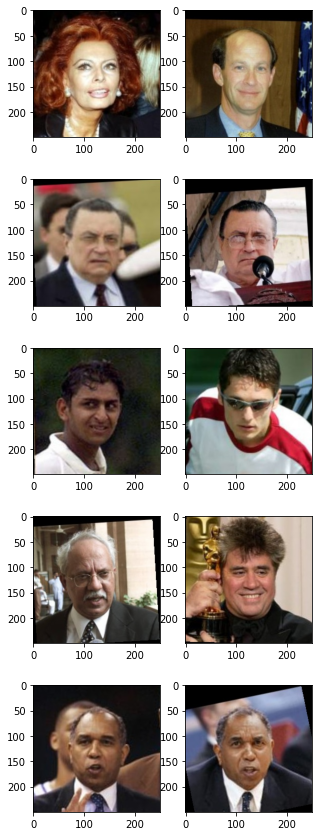

<IPython.core.display.Javascript object>

In [20]:
for imgs, labels in train_ds:
    break
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(5, 15)
for i in range(5):
    im_1 = (imgs[i].numpy()[:250] + 1) / 2
    im_2 = (imgs[i].numpy()[250:] + 1) / 2
    axs[i, 0].imshow(im_1)
    axs[i, 1].imshow(im_2)

## Modelling

### Feature extractor

For the feature extractor a CNN with around 1 million parameters. This CNN is formed by 4 convolutional blocks that include a batch normalization layer, followed by a convolutional layer with relu activation function, a dropout layer and a max pooling layer. The architechture detail exposed below is the result of iteration and refinement of the CNN. The strategy followed was to first to look for an architechture big enough to fit (or overfit) the training data, and then regularize such architechture by using the dropout layers.

In [21]:
inputs = keras.layers.Input([250, 250, 3], dtype=tf.float32)
# B1
x = keras.layers.BatchNormalization()(inputs)
x = keras.layers.Conv2D(20, 5, strides=(2, 2), activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(40, 3, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B3
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(80, 3, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B4
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(150, 3, strides=(3, 3), activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Conv2D(400, 4, strides=(4, 4), activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
features_extracted = keras.layers.Flatten()(x)
feature_extraction_model = keras.Model(inputs, features_extracted)

<IPython.core.display.Javascript object>

In [22]:
feature_extraction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 123, 123, 20)      1520      
                                                                 
 dropout (Dropout)           (None, 123, 123, 20)      0         
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 20)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 20)       80    

<IPython.core.display.Javascript object>

### Face pair model

The model is now assembled into a final model by includes 2 dense hidden layer and an output layer over the concatenation of the feature extracted from both inputs.

In [23]:
inputs = keras.layers.Input([500, 250, 3], dtype=tf.float32)
input_x, input_y = tf.split(
    inputs,
    num_or_size_splits=2,
    axis=1,
)
features_x = feature_extraction_model(input_x)
features_y = feature_extraction_model(input_y)
concat_feat = keras.layers.concatenate([features_x, features_y])
dense = keras.layers.Dense(100, activation="relu")(concat_feat)
dense = keras.layers.Dropout(0.3)(dense)
dense = keras.layers.Dense(50, activation="relu")(dense)
dense = keras.layers.Dropout(0.1)(dense)
output = keras.layers.Dense(1, activation="sigmoid")(dense)
model = keras.Model(inputs=inputs, outputs=output)

<IPython.core.display.Javascript object>

The model is compiled using the binary crossentropy loss and the adam optimizer. 

In [24]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC"],
)

<IPython.core.display.Javascript object>

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.split (TFOpLambda)          [(None, 250, 250, 3  0           ['input_2[0][0]']                
                                ),                                                                
                                 (None, 250, 250, 3                                               
                                )]                                                                
                                                                                            

<IPython.core.display.Javascript object>

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

<IPython.core.display.Javascript object>

In [27]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "../data/model_face_pair", save_best_only=True, monitor="val_loss", verbose=False
)

<IPython.core.display.Javascript object>

In [28]:
fit_history = model.fit(
    x=train_ds,
    epochs=50,
    validation_data=cv_ds,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/50


2022-08-05 19:07:11.972952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    250/Unknown - 512s 2s/step - loss: 0.6856 - accuracy: 0.5536 - auc: 0.5754

2022-08-05 19:15:43.965082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 550s 2s/step - loss: 0.6856 - accuracy: 0.5536 - auc: 0.5754 - val_loss: 0.6314 - val_accuracy: 0.6568 - val_auc: 0.6976
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.7094 - auc: 0.7750

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 547s 2s/step - loss: 0.5633 - accuracy: 0.7094 - auc: 0.7750 - val_loss: 0.5114 - val_accuracy: 0.7478 - val_auc: 0.8262
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.7684 - auc: 0.8439

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 544s 2s/step - loss: 0.4849 - accuracy: 0.7684 - auc: 0.8439 - val_loss: 0.4784 - val_accuracy: 0.7724 - val_auc: 0.8597
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8018 - auc: 0.8749

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 547s 2s/step - loss: 0.4366 - accuracy: 0.8018 - auc: 0.8749 - val_loss: 0.4349 - val_accuracy: 0.7934 - val_auc: 0.8812
Epoch 5/50
250/250 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.8202 - auc: 0.8954

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 555s 2s/step - loss: 0.4009 - accuracy: 0.8202 - auc: 0.8954 - val_loss: 0.4238 - val_accuracy: 0.8028 - val_auc: 0.8836
Epoch 6/50
250/250 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8342 - auc: 0.9089

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 577s 2s/step - loss: 0.3736 - accuracy: 0.8342 - auc: 0.9089 - val_loss: 0.3881 - val_accuracy: 0.8257 - val_auc: 0.9105
Epoch 7/50
250/250 [==============================] - 549s 2s/step - loss: 0.3531 - accuracy: 0.8464 - auc: 0.9182 - val_loss: 0.3932 - val_accuracy: 0.8232 - val_auc: 0.9042
Epoch 8/50
250/250 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8563 - auc: 0.9279

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 543s 2s/step - loss: 0.3310 - accuracy: 0.8563 - auc: 0.9279 - val_loss: 0.3875 - val_accuracy: 0.8262 - val_auc: 0.9102
Epoch 9/50
250/250 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8656 - auc: 0.9352

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 544s 2s/step - loss: 0.3138 - accuracy: 0.8656 - auc: 0.9352 - val_loss: 0.3769 - val_accuracy: 0.8362 - val_auc: 0.9174
Epoch 10/50
250/250 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8733 - auc: 0.9397

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 541s 2s/step - loss: 0.3006 - accuracy: 0.8733 - auc: 0.9397 - val_loss: 0.3523 - val_accuracy: 0.8457 - val_auc: 0.9233
Epoch 11/50
250/250 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8764 - auc: 0.9437

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 548s 2s/step - loss: 0.2912 - accuracy: 0.8764 - auc: 0.9437 - val_loss: 0.3509 - val_accuracy: 0.8504 - val_auc: 0.9282
Epoch 12/50
250/250 [==============================] - 537s 2s/step - loss: 0.2780 - accuracy: 0.8831 - auc: 0.9484 - val_loss: 0.3531 - val_accuracy: 0.8447 - val_auc: 0.9281
Epoch 13/50
250/250 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8887 - auc: 0.9516

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 542s 2s/step - loss: 0.2686 - accuracy: 0.8887 - auc: 0.9516 - val_loss: 0.3472 - val_accuracy: 0.8504 - val_auc: 0.9299
Epoch 14/50
250/250 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8930 - auc: 0.9536

INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair/assets


250/250 [==============================] - 543s 2s/step - loss: 0.2621 - accuracy: 0.8930 - auc: 0.9536 - val_loss: 0.3460 - val_accuracy: 0.8549 - val_auc: 0.9318
Epoch 15/50
250/250 [==============================] - 539s 2s/step - loss: 0.2501 - accuracy: 0.8975 - auc: 0.9575 - val_loss: 0.3603 - val_accuracy: 0.8495 - val_auc: 0.9300
Epoch 16/50
250/250 [==============================] - 550s 2s/step - loss: 0.2488 - accuracy: 0.8987 - auc: 0.9580 - val_loss: 0.3564 - val_accuracy: 0.8511 - val_auc: 0.9369
Epoch 17/50
250/250 [==============================] - 548s 2s/step - loss: 0.2387 - accuracy: 0.9037 - auc: 0.9609 - val_loss: 0.3517 - val_accuracy: 0.8522 - val_auc: 0.9332
Epoch 18/50
250/250 [==============================] - 539s 2s/step - loss: 0.2303 - accuracy: 0.9075 - auc: 0.9638 - val_loss: 0.3570 - val_accuracy: 0.8481 - val_auc: 0.9280
Epoch 19/50
250/250 [==============================] - 539s 2s/step - loss: 0.2272 - accuracy: 0.9081 - auc: 0.9644 - val_loss: 0.35

<IPython.core.display.Javascript object>

### Model exploration

In [21]:
model = keras.models.load_model("../data/model_face_pair")

<IPython.core.display.Javascript object>

Model AUC - Training

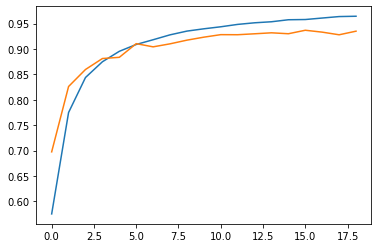

<IPython.core.display.Javascript object>

In [32]:
plt.plot(fit_history.history["auc"])
plt.plot(fit_history.history["val_auc"])

Model Accuracy - Training

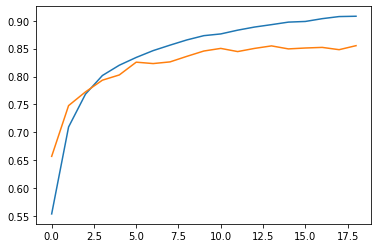

<IPython.core.display.Javascript object>

In [35]:
plt.plot(fit_history.history["accuracy"])
plt.plot(fit_history.history["val_accuracy"])

In [44]:
results = pd.DataFrame(columns=["label", "proba"])
for x, y in test_ds:
    y_pred = model.predict(x, verbose=0)
    results = pd.concat(
        [
            pd.DataFrame(
                columns=["label", "proba"],
                data=np.concatenate([y.numpy().reshape(-1, 1), y_pred], axis=1),
            ),
            results,
        ]
    )

<IPython.core.display.Javascript object>

The model performs well on the test set achieving an accuracy close to 90% and an AUC of 0.96. The confussion matrix is pretty balanced and displays the predictive power of the model

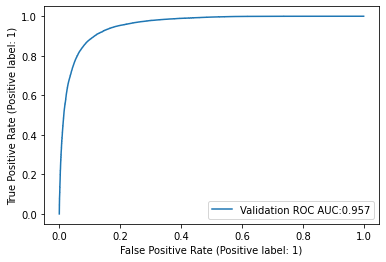

<IPython.core.display.Javascript object>

In [46]:
RocCurveDisplay.from_predictions(
    results["label"],
    results["proba"],
    label=f"Validation ROC AUC:{round(roc_auc_score(results['label'], results['proba']),3)}",
)

In [47]:
results["prediction"] = results["proba"].apply(lambda x: int(x > 0.5))

<IPython.core.display.Javascript object>

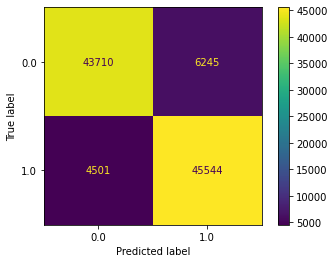

<IPython.core.display.Javascript object>

In [48]:
ConfusionMatrixDisplay.from_predictions(results["label"], results["prediction"])

Let's look at some missclassified pictures lo investigate where the model is failing.

In [73]:
misclassified = x.numpy()[(y_pred.reshape(-1) > 0.5).astype(int) != y.numpy()]

<IPython.core.display.Javascript object>

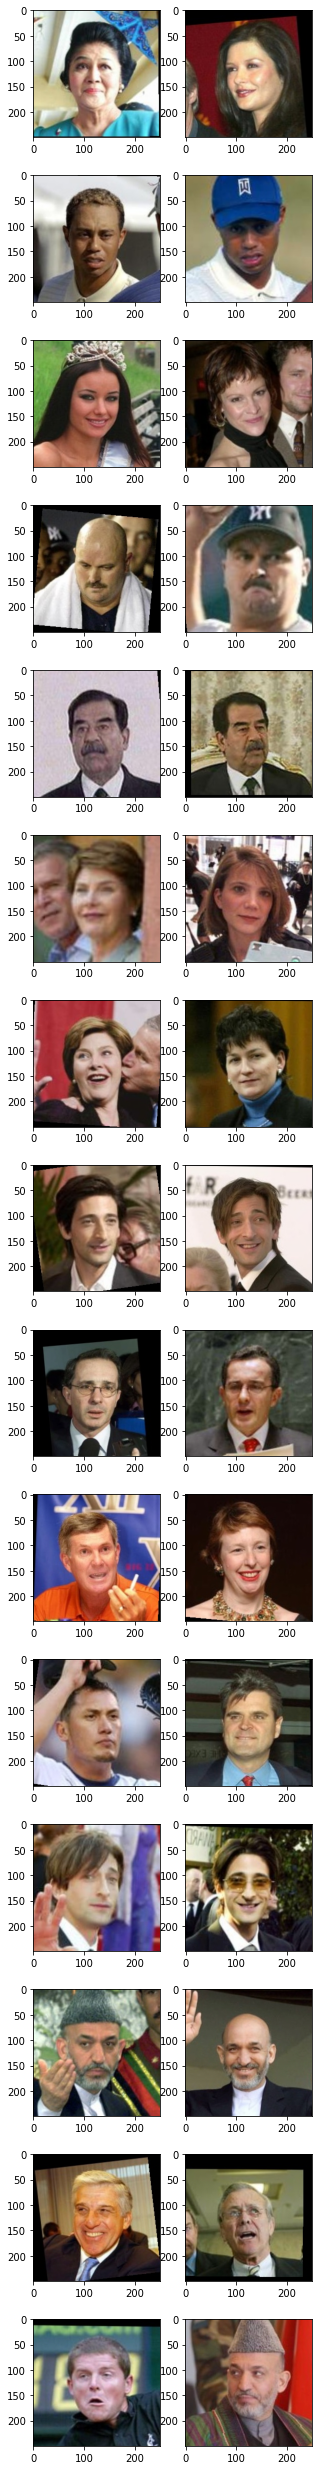

<IPython.core.display.Javascript object>

In [81]:
num_miss = min(15, len(misclassified))
fig, axs = plt.subplots(num_miss, 2)
fig.set_size_inches(5, 3 * num_miss)
for i, ims in enumerate(misclassified):
    if i >= num_miss:
        break
    im_1 = (ims[:250] + 1) / 2
    im_2 = (ims[250:] + 1) / 2
    axs[i, 0].imshow(im_1)
    axs[i, 1].imshow(im_2)

It seems that the model has trouble when people use accesories like hats and glasses. It also seems that appearence changes including different hair styles throw the model off.

## Conclusion

Using Keras and the LFW - Facial recognition dataset a face pairing model was constructed. This model has a lot of predictive power and is capable of recognizing if two pictures come from the same person with an accuracy of 90% (in a test set formed by pictures of LFW). It is woroth mentioning that the model is biased by the dataset used to construct it, and should not be used commercially. In further iterations the model could be improved by enhancing data augmentation, trying more model architechtures and constructing a more robust training dataset.